In [1]:
import os.path as osp
import numpy as np
import numpy.linalg as npla
import scipy.spatial.transform as sptf
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 14,
})

np.set_printoptions(6, suppress=True)

from pylgmath import se3op, Transformation
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.p2p import P2PErrorEvaluator as p2p_error

import utils

def rpy2rot(y, p, r):
    roll = lambda r: np.array([[1, 0, 0], [0, np.cos(r), np.sin(r)], [0, -np.sin(r), np.cos(r)]], dtype=np.float64)
    pitch = lambda p: np.array([[np.cos(p), 0, -np.sin(p)], [0, 1, 0], [np.sin(p), 0, np.cos(p)]], dtype=np.float64)
    yaw = lambda y: np.array([[np.cos(y), np.sin(y), 0], [-np.sin(y), np.cos(y), 0], [0, 0, 1]], dtype=np.float64)
    return roll(r) @ pitch(p) @ yaw(y)


def convert_line_to_pose(line):
    # returns T_iv
    line = line.replace('\n', ',').split(',')
    line = [float(i) for i in line[:-1]]
    # x, y, z -> 1, 2, 3
    # roll, pitch, yaw -> 7, 8, 9
    T = np.eye(4, dtype=np.float64)
    T[0, 3] = line[1]  # x
    T[1, 3] = line[2]  # y
    T[2, 3] = line[3]  # z
    T[:3, :3] = rpy2rot(line[9], line[8], line[7])

    return T


def load_pred_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        T_ms = np.eye(4)
        T_ms[:3, :] = v.reshape(3, 4)
        poses.append(T_ms)
    return np.array(poses)


def load_gt_poses(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    poses = []
    for line in lines[1:]:
        pose = convert_line_to_pose(line)
        poses.append(pose)

    T_s0_m = npla.inv(poses[0])
    poses = [T_s0_m @ T_ms for T_ms in poses]
    return np.array(poses)


def plot_pred_poses(ax, filename, gt_poses, label):
    pred_poses = load_pred_poses(filename)
    T_gt_pred = utils.align_path(gt_poses, pred_poses)
    # T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3], pred_poses[:, 1, 3], label=label)


gt_path = '/home/yuchen/ASRL/data/boreas/sequences/'
pred_path = '/home/yuchen/ASRL/temp/doppler_odometry/boreas/aeva'
sequences = [
    'boreas-2022-07-19-16-06',
    'boreas-2022-08-05-12-59',
    'boreas-2022-08-05-13-30',
    'boreas-2022-08-05-13-54',
    'boreas-2022-08-05-15-01',
]

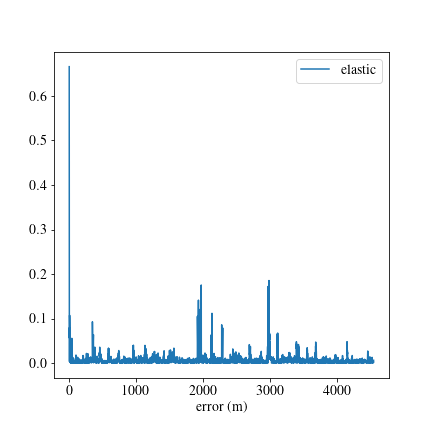

In [3]:
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# error_file = 'elastic'
# error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:2000]
# ax.plot(error, label='elastic')
# # ax.hist(error, bins=30, range=(0., 0.15), label='elastic')

# error_file = 'steam_0804_2'
# error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:2000]
# ax.plot(error, label='steam')
# # ax.hist(error, bins=30, range=(0., 0.15), label='steam')

# error_file = 'steam_0804_2_rv'
# error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:2000]
# ax.plot(error, label='steam-rv')
# # ax.hist(error, bins=30, range=(0., 0.15), label='steam-rv')

# error_file = '0807_debug/elastic'
# error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:, 0]
# ax.plot(error, label='elastic')
# # ax.hist(error, bins=30, range=(0., 0.15), label='elastic')

# error_file = '0807_debug/default'
# error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:2000]
# ax.plot(error, label='steam-rv')
# # ax.hist(error, bins=30, range=(0., 0.15), label='steam-rv')

# error_file = '0807_debug/qc_diag_100_10'
# error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))
# ax.plot(error, label='steam-rv')
# ax.hist(error, bins=30, range=(0., 0.15), label='steam-rv')

error_file = '0807_debug/steam_window1'
error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:, 0]
ax.plot(error, label='steam-window1')
# ax.hist(error, bins=30, range=(0., 0.15), label='steam-rv')

error_file = '0807_debug/steam_temp'
error = np.loadtxt(osp.join(pred_path, error_file, sequence+'_eval.txt'))[:, 0]
ax.plot(error, label='steam-temp')
# ax.hist(error, bins=30, range=(0., 0.15), label='steam-rv')


# ax.set_xlabel('frame')
ax.set_xlabel('error (m)')
ax.legend()

plt.show()

In [ ]:
sequence = sequences[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# ground truth
gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))
ax.plot(gt_poses[:, 0, 3], gt_poses[:, 1, 3], label='ground truth')

pred_file = 'elastic_reduced'
plot_pred_poses(ax, osp.join(pred_path, pred_file, sequence+'_poses.txt'), gt_poses, 'elastic-reduced')

# pred_file = 'steam_0804_2'
# plot_pred_poses(ax, osp.join(pred_path, pred_file, sequence+'_poses.txt'), gt_poses, 'p2p')

pred_file = 'steam_0804_2_reduced'
plot_pred_poses(ax, osp.join(pred_path, pred_file, sequence+'_poses.txt'), gt_poses, 'steam-reduced')

pred_file = 'steam_0804_2_rv_reduced'
plot_pred_poses(ax, osp.join(pred_path, pred_file, sequence+'_poses.txt'), gt_poses, 'steam-rv-reduced')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(sequence)
ax.legend()

plt.show()

In [ ]:
def add_plot_pose(ax, filename, label=None):
    error = np.loadtxt(filename)
    timestamps = error[:, 1] / 1e9
    T_rm = error[:, 2:18].reshape(-1, 4, 4)
    T_mr_vec = se3op.tran2vec(T_rm).squeeze()

    ax[0, 0].plot(timestamps, T_mr_vec[:, 0], label=label)
    ax[1, 0].plot(timestamps, T_mr_vec[:, 1], label=label)
    ax[2, 0].plot(timestamps, T_mr_vec[:, 2], label=label)
    ax[0, 1].plot(timestamps, T_mr_vec[:, 3+0], label=label)
    ax[1, 1].plot(timestamps, T_mr_vec[:, 3+1], label=label)
    ax[2, 1].plot(timestamps, T_mr_vec[:, 3+2], label=label)

def add_plot_velocity(ax, filename, label=None):
    error = np.loadtxt(filename)
    timestamps = error[:, 1] / 1e9
    w_mr_inr = error[:, 18:24]  # n by 6
    ax[0, 0].plot(timestamps, w_mr_inr[:, 0], label=label)
    ax[1, 0].plot(timestamps, w_mr_inr[:, 1], label=label)
    ax[2, 0].plot(timestamps, w_mr_inr[:, 2], label=label)
    ax[0, 1].plot(timestamps, w_mr_inr[:, 3+0], label=label)
    ax[1, 1].plot(timestamps, w_mr_inr[:, 3+1], label=label)
    ax[2, 1].plot(timestamps, w_mr_inr[:, 3+2], label=label)


def add_legend(ax, prefix = "velocity"):
    legend = [['x', 'y', 'z'], ['roll', 'pitch', 'yaw']]
    for i in range(3):
        for j in range(2):
            ax[i, j].set_xlabel('time [s]')
            ax[i, j].set_ylabel(prefix + ' ' + legend[j][i])
            ax[i, j].legend()

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

add_plot_velocity(ax, '/home/yuchen/ASRL/temp/doppler_odometry/boreas/aeva/0807_debug/steam_temp/trajectory.txt', 'debug')

add_legend(ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

add_plot_pose(ax, '/home/yuchen/ASRL/temp/doppler_odometry/boreas/aeva/0807_debug/steam_temp/trajectory.txt', 'debug')

add_legend(ax)
plt.show()